# Donald Trump's personality assesment with Twitter and IBM Watson

Much has been written about Donald Trump’s character in relation to his fitness for office but very little of it was grounded in science. By building on previous research to label the data and leveraging IBM's Personality Insight API, this analysis of Trump's twitter communications will allow us to gain insights into Donald J. Trump's personality as well as his mindset during the 2016 presidential election.

## The Data
![data preprocessing](./doc/data_flow.png)

The dataset was acquired from Brendan Brown's [Trump Twitter Archive](www.trumptwitterarchive.com/about) and contains all the publicly available and deleted tweets from the **@realDonaldTrump** account from 2009 up to the 13th August 2020.  

Retweets and manual retweets were excluded at download and after de-duplication, over **35 thousand communications** remained. The raw csv file is included in the data folder of this project's repository [add a link here].

For any politician, **multiple staff** members express themselves through a single account and are therefore identified to be a **single individual**. Not only does this makes it difficult for the public to understand who their elected official really is, but it would skew our personality analysis as well. 

Thanks to Dr. James Allen-Robertson and his [deep learning approach to recognizing Trump's tweets](https://towardsdatascience.com/finding-trump-with-neural-networks-4419468e0624), we know it is possible to use machine learning to predict if the president was really behind the keyboard. A simple Naive Bayes classifier with **81% accuracy** on unseen data was used to pre-label the data.

The model's classification was then verified qualitatively and re-labeled by hand when necessary, resulting in a total of XX messages from Trump's staff and XX of his own.  

In [4]:
import pandas, numpy

tweets = pandas.read_csv('./data/realdonaldtrump.csv', 
                       parse_dates=['date'],
                       index_col=['date'],
                       usecols=['date', 'content'],
                       encoding='utf-8')

tweets.head(3)

,content
date,
2009-05-04 13:54:25,Be sure to tune in and watch Donald Trump on L...
2009-05-04 20:00:10,Donald Trump will be appearing on The View tom...
2009-05-08 08:38:08,Donald Trump reads Top Ten Financial Tips on L...


## Contacting IBM Watson and the Personality Insights API:
In order to move quickly to our objective we will utilize IBM's Watson Personality Insights API.


![personality insights landing page](./doc/IBM-Personality_Insights.png)
>Gain insight into how and why people think, act, and feel the way they do. This service applies linguistic analytics and personality theory to infer attributes from a person's unstructured text. 

If you want to known more about the science behind the service, [click here.](https://cloud.ibm.com/docs/personality-insights?topic=personality-insights-science) But in short, by using thousands of twitter surveys (International Personality Item Pool or IPIP) as well as in-house research, IBM created a machine learning regressor based on the Five Factor and NEO-PI models to infer personality traits, values and needs of a social media user. 

A demonstration is available [here](https://personality-insights-demo.ng.bluemix.net/) but if you wish to use the service regularely, please apply for an API key as follow;
- [Sign up for an IBM Cloud account](https://cloud.ibm.com/registration?)
- Create an instance of the Personality Insights service and get your credentials:
     - Go to the Personality Insights page in the IBM Cloud Catalog.
     - Click Create.
     - Click Show to view the service credentials.

In [162]:
import getpass

# prompt for API credentials
API_URL = getpass.getpass('Your instance url: ')
API_KEY = getpass.getpass('Your API key: ')

Your instance url:  ···········································································································
Your API key:  ············································


In [163]:
import sys, requests 
from io import StringIO

def get_profile_data(text):
    """
    Send request to the Personality Insights API
    Note: data max size is 20Mb and min size is 100 words
    """    
    # check size limit
    assert (sys.getsizeof(text)*1e-6) <= 20.0, 'Text data > 20Mb'
    assert len(text.split()) > 100, 'Text data < 100 words'
    
    # prepare api version, csv parameters and headers
    url = API_URL + '/v3/profile?version=2017-10-13&csv_headers=true'
    headers = {
        'Content-Type': 'text/plain;charset=utf-8',
        'Accept': 'text/csv',
    }
    # send request 
    response = requests.post(url, headers=headers, 
                             auth=('apikey', API_KEY), 
                             data=text.encode('utf-8'))
    # response to df
    result = StringIO(str(response.content.decode("utf-8") ))
    result_df = pandas.read_csv(result)
    
    return result_df 

*Note: Due to the API's limitations (20Mb), only the last 30K tweets will be used to build the account's general profile.*

In [164]:
# concat last 30K tweets     
text_data = ' '.join(tweets.tail(30000).content)

# request profile 
general_profile = get_profile_data(text_data)

# save and display profile
general_profile.to_csv('./data/general_profile.csv', index=False)
general_profile

,big5_agreeableness,facet_altruism,facet_cooperation,facet_modesty,facet_morality,facet_sympathy,facet_trust,big5_conscientiousness,facet_achievement_striving,facet_cautiousness,...,need_challenge_significant,need_closeness_significant,need_curiosity_significant,need_excitement_significant,need_harmony_significant,value_conservation_significant,value_hedonism_significant,value_openness_to_change_significant,value_self_enhancement_significant,value_self_transcendence_significant
0,0.638308,0.870628,0.617919,0.056688,0.716919,0.894446,0.76559,0.702012,0.933529,0.686098,...,True,True,True,True,True,True,True,True,True,True


## So, what are the big five personality traits?

The Big Five Model, also known as the Five-Factor Model, is the most widely accepted **personality theory** held by psychologists today. At least four sets of researchers have worked for decades on this problem and have identified generally the same five factors; **extraversion**, **agreeableness**, **openness**, **conscientiousness**, and **neuroticism**.

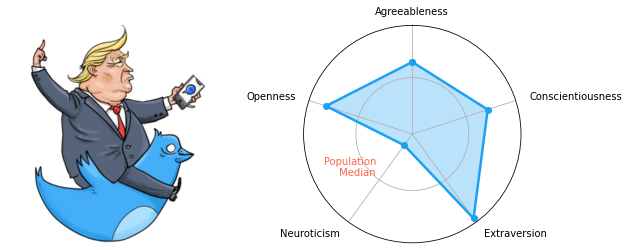

In [6]:
from math import pi
from PIL import Image
import matplotlib.pyplot as plt


# change plot size 
plt.rcParams['figure.figsize'] = [10,4]

def plot_img(path, ax):
    """
    Plot image in axis
    """
    image = Image.open(path)
    ax.imshow(image)
    ax.axis('off')    
    
def category_plot_radar(category_name, data, ax=plt.subplot(polar=True)):
    """
    Radar plot type of personality profile: big5 or facet
    """
    column_selection = [ column for column in data.columns \
                        if category_name in column \
                        and not any(word in column for word in ['raw', 'significant']) ]
    
    # closing the plot by repeating the first value
    values = data[column_selection].values.tolist()[0]
    values += values[:1]
    
    # determine angles for category
    m = len(column_selection)
    angles = numpy.linspace(0, 2 * numpy.pi, m, endpoint=False).tolist()
    angles += angles[:1]
    
    # radar plot 
    ax.plot(angles, values, marker='.', color='#1da1f2', 
            linewidth=2.5, markersize=12)
    ax.fill(angles, values, color='#1da1f2', alpha=0.3)
    
    # fix axis to vertical alignment 
    ax.set_theta_offset(numpy.pi / 2)
    ax.set_theta_direction(-1)
    
    # xticks
    plt.xticks(angles[:-1], [' '.join(col.split('_')[1:]).title() \
                                     for col in column_selection])
    
    # adjust xtick label alignment based on it's position on the circle.
    for label, angle in zip(ax.get_xticklabels(), angles):
        if angle in (0, numpy.pi):
            label.set_horizontalalignment('center')
        elif 0 < angle < numpy.pi:
            label.set_horizontalalignment('left')
        else:
            label.set_horizontalalignment('right')
    # ytick 
    ax.set_rlabel_position(220)
    plt.yticks([0.5], ['Population\n Median'], color='tomato', ha='right')
    
    
# plotting big5 as bar plot 
big5 = general_profile[[ column for column in general_profile.columns \
                        if 'big5' in column \
                        and not any(word in column for word in ['raw', 'significant']) ]]
# plot image 
ax1 = plt.subplot(121)
plot_img('./doc/trump-tweet-1.png', ax=ax1)
#ax1.set_title('@realDonaldTrump', loc='left', fontsize=18)

# plotting traits as radar 
ax2 = plt.subplot(122, polar=True)
category_plot_radar('big5', general_profile, ax=ax2)

*Note: You can have a look [here](https://medium.com/python-in-plain-english/radar-chart-basics-with-pythons-matplotlib-ba9e002ddbcd) if you want to learn more about radar plots with matplotlib.*

**Openness**, is the tendency to be imaginative, open to new ideas, curious and creative. People who score high in openness are often interested in creative pursuits.

**Conscientiousness** is about having attention to detail and a good work ethic. People who score highly in conscientiousness tend to want to get things done on time, the proper way, and tend to follow rules.

**Agreeableness**, like extraversion, is about interpersonal style. People who score highly on agreeableness tend to be warm, trusting, kind and cooperative. They tend to adjust to others, rather than forcing their own ways on them.

**Neuroticism** refers to the tendency to respond with negative emotions to threat, frustration, or loss, like anxiety, sadness, anger, envy and jealousness. People who score highly on neuroticism tend to experience frequent and intense emotional reaction, while people who score lower tend to be more emotionally stable and calm.

**Extraversion** is the trait most associated with those who like to be the life of the party, those people who really enjoy socialising and spending time with others. If you'd prefer to snuggle up with a good book by yourself rather than head to the pub, you're likely to score lower on extraversion.  

## The relationship between Traits and Facets
One common criticism of the Big Five is that it does not explain all of human behavioral aspects as it only represents broad personality domains. To add granularity to the Five Factors, the **NEO-PI model** was developed and further improved by Paul Costa and Robert McCrae. It subdivides each of the five traits into collections of 6 facets: 

In [7]:
# selecting only big5 and facets 
bi5_and_facets = [col for col in general_profile.columns \
                  if any(domain in col for domain in \
                         ['big5', 'facet']) \
                  and not 'significant' in col]

# group facets by big5 (split list every seven items)
facet_groups = [bi5_and_facets[n:n+7] \
                for n in range(0, len(bi5_and_facets), 7)]

# group to dictionary with formated traits as keys 
facet_groups = {group[0].split('_')[1].title(): group[1:] for group in facet_groups}

# place neuroticism to the end 
facet_groups['Neuroticism'] = facet_groups.pop('Neuroticism')

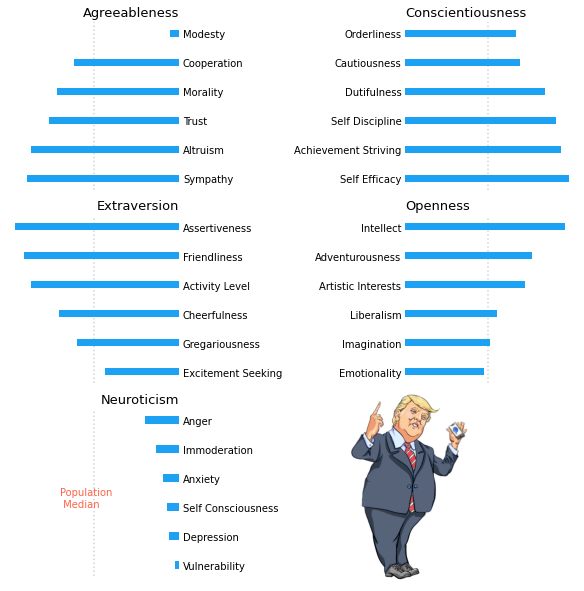

In [33]:
# prepare axes 
fig, axes = plt.subplots(ncols=2, nrows=3, constrained_layout=True, sharex='col')
axes = [ax for sublist in axes for ax in sublist]
#axes[-1].remove()

# change plot size 
plt.rcParams['figure.figsize'] = [8,8]

color_groups = []

for i, (ax, (trait, facets)) in enumerate(zip(axes, facet_groups.items())):
    # invert axis for symmetry
    ax.invert_xaxis()
    
    # plot population median 
    ax.axvline(0.5, color='lightgrey', linestyle=':', zorder=0)
    
    # move y ticks for symmetry 
    ax.yaxis.tick_right()
    if i%2 > 0: ax.yaxis.tick_left()
    
    # special sorting for the two top plots
    ascending = True
    if i in [0, 1]: ascending = False
    
    # prepare data to plot 
    df = general_profile[facets].sort_values(by=0, ascending=ascending, axis=1)
    error = numpy.random.rand(len(df.columns))
    columns = [' '.join(title.split('_')[1:]).title() for title in df.columns]
    
    # plot facets
    ax.barh(columns, df.values[0], color='#1da1f2', align='center', height=0.25)
    ax.set_title(trait, loc=('right', 'left')[i%2>0], fontsize=13)
    
    # remove spines and ticks 
    for spine in ['left', 'right', 'bottom', 'top']:
        ax.spines[spine].set_visible(False)
    ax.tick_params(axis='both', which='both',length=0)
    ax.set_xticklabels([])
    
    # add legend to Neuroticism ax
    if trait == 'Neuroticism':
        ax.text(0.7, 2, 'Population\n Median', color='tomato')


# reposition axes to fit image in the graph
pos = axes[-1].get_position()
pos.x0 = 0.6       
pos.y0 = -0.03
axes[-1].set_position(pos)

# remove shared x axes
axis_group = axes[-1].get_shared_x_axes()
axis_group.remove(axes[-1])

# plot image
plot_img('./doc/trump-tweet-5.png', axes[-1])


## 3. Personality timeline:
A general profile is useful to comprehend the psychological baseline of a person. Howerver, the aim of this analysis is to discover the evolution of the user's mindset during the span of the available data (11 years).

Due to the large number of communications, plotting successive profiles from quarterly resampled tweets helps develop such insight;

In [167]:
%%time

df_list = []
# resample by quarter
for quarter, data in tweets.groupby(pandas.PeriodIndex(tweets.index, freq='Q')):
    print(f'[INFO] Period {quarter}: {data.shape[0]} tweets')

    # fetch the profile for this period
    df = get_profile_data(data.content)
    df['date'] = quarter
    
    # append to result list 
    df_list.append(df)

# concat results
quarterly_profile = pandas.concat(df_list)
quarterly_profile.set_index('date', inplace=True)

# save and display 
quarterly_profile.to_csv('./data/timeline_profile.csv')
quarterly_profile.head(3)

[INFO] Period 2009Q2: 32 tweets
[INFO] Period 2009Q3: 15 tweets
[INFO] Period 2009Q4: 9 tweets
[INFO] Period 2010Q1: 18 tweets
[INFO] Period 2010Q2: 52 tweets
[INFO] Period 2010Q3: 43 tweets
[INFO] Period 2010Q4: 30 tweets
[INFO] Period 2011Q1: 61 tweets
[INFO] Period 2011Q2: 62 tweets
[INFO] Period 2011Q3: 287 tweets
[INFO] Period 2011Q4: 459 tweets
[INFO] Period 2012Q1: 645 tweets
[INFO] Period 2012Q2: 705 tweets
[INFO] Period 2012Q3: 1062 tweets
[INFO] Period 2012Q4: 1781 tweets
[INFO] Period 2013Q1: 2611 tweets
[INFO] Period 2013Q2: 2168 tweets
[INFO] Period 2013Q3: 2104 tweets
[INFO] Period 2013Q4: 1320 tweets
[INFO] Period 2014Q1: 1071 tweets
[INFO] Period 2014Q2: 1675 tweets
[INFO] Period 2014Q3: 1335 tweets
[INFO] Period 2014Q4: 1920 tweets
[INFO] Period 2015Q1: 2097 tweets
[INFO] Period 2015Q2: 2023 tweets
[INFO] Period 2015Q3: 1582 tweets
[INFO] Period 2015Q4: 2003 tweets
[INFO] Period 2016Q1: 1367 tweets
[INFO] Period 2016Q2: 903 tweets
[INFO] Period 2016Q3: 893 tweets
[INFO

,big5_agreeableness,facet_altruism,facet_cooperation,facet_modesty,facet_morality,facet_sympathy,facet_trust,big5_conscientiousness,facet_achievement_striving,facet_cautiousness,...,need_challenge_significant,need_closeness_significant,need_curiosity_significant,need_excitement_significant,need_harmony_significant,value_conservation_significant,value_hedonism_significant,value_openness_to_change_significant,value_self_enhancement_significant,value_self_transcendence_significant
date,,,,,,,,,,,,,,,,,,,,,
2009Q2,0.608295,0.828331,0.620377,0.218761,0.606911,0.756528,0.642125,0.593971,0.883936,0.797552,...,True,True,True,True,True,True,True,True,True,True
2009Q3,0.378976,0.721257,0.825542,0.379300,0.797422,0.649490,0.845256,0.804475,0.939655,0.909473,...,True,True,True,True,True,True,True,True,True,True
2009Q4,0.470713,0.908558,0.858726,0.069850,0.712263,0.699253,0.964037,0.508054,0.983068,0.703330,...,True,True,True,True,True,True,True,True,True,True


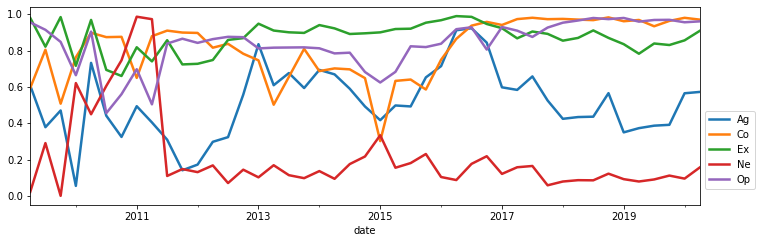

In [477]:
quarterly_profile = pandas.read_csv('./data/timeline_profile.csv', parse_dates=['date'], index_col=['date'])

# change plot size
plt.rcParams['figure.figsize'] = [12,8]

def category_plot_line(category_name, data, legend=False, ax=None):
    """
    Plots a timeline of a type of personality profile: big5 or facet
    """
    column_selection = [ column for column in data.columns \
                    if category_name in column \
                    and not any(word in column for word in ['raw', 'significant']) ]
    # plotting
    data[column_selection].plot(ax=ax, linewidth=2.5)
    if legend:
        # formatting labels 
        labels = [' '.join(trait.split('_')[1:]).title()[:2] for trait in column_selection]
        plt.legend(labels, loc='best', bbox_to_anchor=(1.0, 0.5));

# big5 axis
ax3 = plt.subplot(212, sharex=ax1)
category_plot_line('big5', quarterly_profile, ax=ax3, legend=True)

Extracting the facets with the most variations starting from 2012.

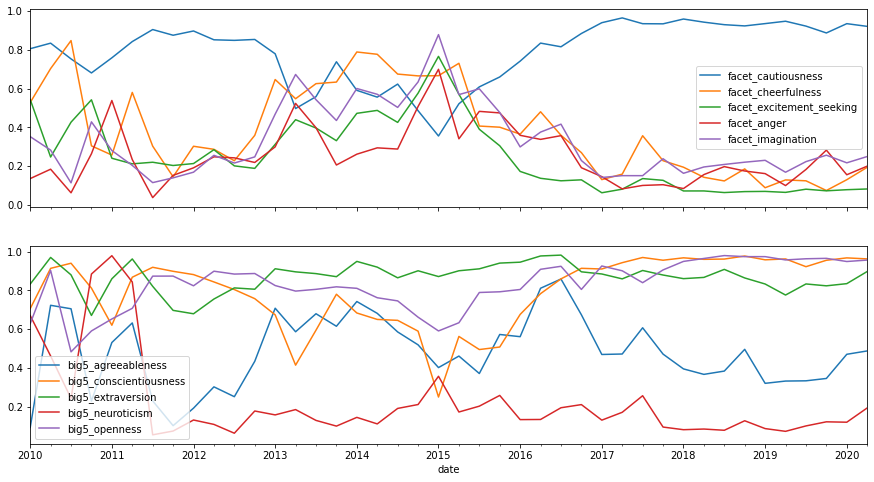

In [59]:
quarterly_facet = quarterly_profile[[ column for column in quarterly_profile.columns \
                    if 'facet' in column \
                    and not any(word in column for word in ['raw', 'significant']) ]]

quarterly_facet_selection =  quarterly_facet.columns[(quarterly_facet[quarterly_facet.index > '2012']
                                                    .apply(lambda x: x.max()-x.min(), axis=0) > 0.6)]
# facet axis
ax1 = plt.subplot(211)
category_plot_line('facet', quarterly_profile[quarterly_facet_selection], ax=ax1, legend=True)

# big5 axis
ax3 = plt.subplot(212, sharex=ax1)
category_plot_line('big5', quarterly_profile, ax=ax3, legend=True)

The correlation between important life events and distress in the user's base character seem to appear clearly by adding the following timeline;

In [170]:
life_events = {
    '2011Q2': 'Infamous White House Correspondance',
    '2013Q2': 'First contact with Russia',
    '2015Q1': "Hilary Clinton's Email",
    '2016Q4': 'Won the Persidential Election'
}

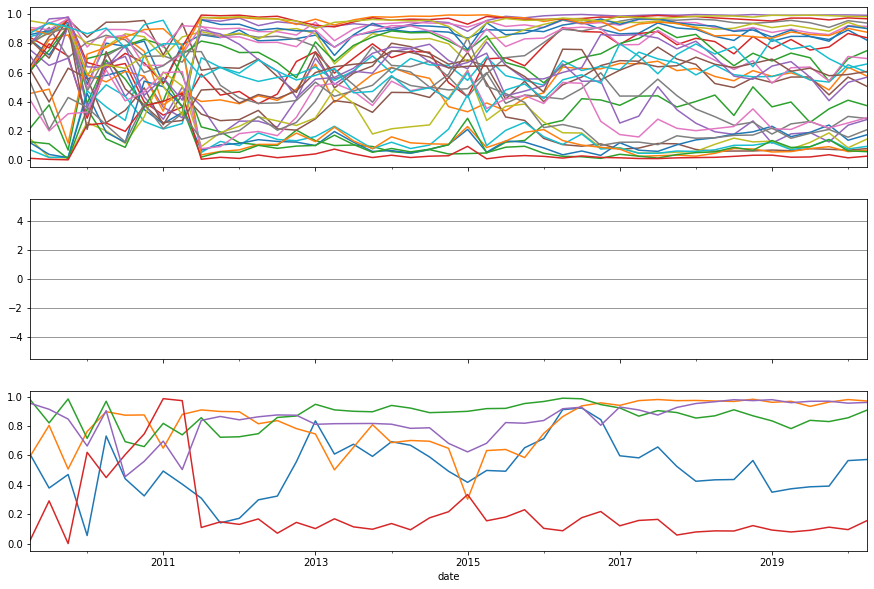

In [90]:
life_events = pandas.DataFrame(list(life_events.items()), 
                                columns=['date', 'event'])

# change plot size
plt.rcParams['figure.figsize'] = [15,10]

# facet axis
ax1 = plt.subplot(311)
category_plot_line('facet', quarterly_profile, ax=ax1)



# timeline axis
ax2 = plt.subplot(312, sharex=ax1)

levels = numpy.tile([-5, 5, -3, 3, -1, 1],
                 int(numpy.ceil(len(dates)/6)))[:len(dates)]

markerline, stemlines, baseline = ax2.stem(dates, levels, '-.', use_line_collection=True)

# setting property of baseline with color red and linewidth 2
ax2.grid(color='gray', axis='y')
#ax2.box(False)



# big5 axis
ax3 = plt.subplot(313, sharex=ax1)
category_plot_line('big5', quarterly_profile, ax=ax3)

<ipython-input-153-efa800c76d82>:11: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  markerline, stemlines, baseline = ax.stem(dates, levels, '-.')


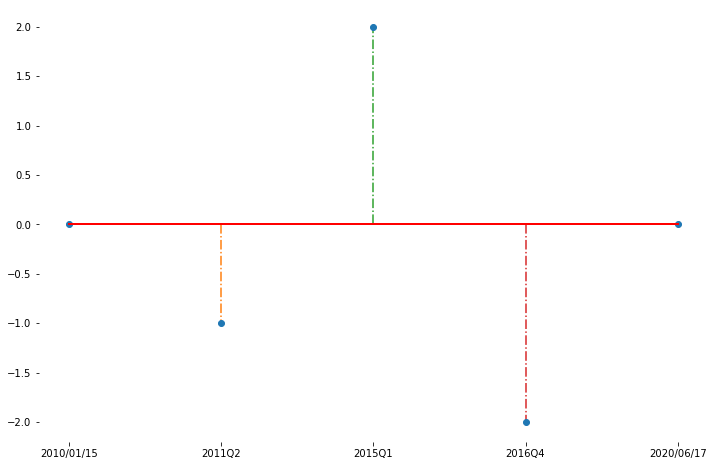

In [153]:
import matplotlib.pyplot as plt
import numpy as np

ax = plt.subplot()

dates = [tweets.index.min().strftime('%Y/%m/%d'), '2011Q2', '2015Q1', '2016Q4', tweets.index.max().strftime('%Y/%m/%d')]

levels = numpy.tile([0, -1, 2, -2, 0],
                 int(numpy.ceil(len(dates)/6)))[:len(dates)]

markerline, stemlines, baseline = ax.stem(dates, levels, '-.')

# setting property of baseline with color red and linewidth 2
plt.setp(baseline, color='r', linewidth=2)


plt.box(False)
plt.show() 

['big5_agreeableness', 'big5_conscientiousness', 'big5_extraversion', 'big5_neuroticism', 'big5_openness']


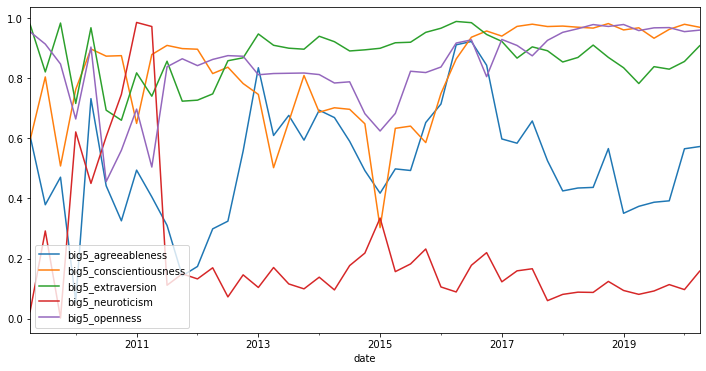

In [133]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12,6]

# selecting Big-5
column_selection = [ col for col in yearly_profile.columns if 'big5' in col and not 'raw' in col and not 'significant' in col ]
print(column_selection)
quarterly_profile[column_selection].plot()

In [103]:
yearly_profile

,big5_agreeableness,facet_altruism,facet_cooperation,facet_modesty,facet_morality,facet_sympathy,facet_trust,big5_conscientiousness,facet_achievement_striving,facet_cautiousness,...,need_challenge_significant,need_closeness_significant,need_curiosity_significant,need_excitement_significant,need_harmony_significant,value_conservation_significant,value_hedonism_significant,value_openness_to_change_significant,value_self_enhancement_significant,value_self_transcendence_significant
date,,,,,,,,,,,,,,,,,,,,,
2009,0.539638,0.830828,0.742322,0.188165,0.700462,0.725262,0.793849,0.687650,0.941183,0.841665,...,True,True,True,True,True,True,True,True,True,True
2010,0.444773,0.772558,0.798184,0.768737,0.546722,0.534996,0.941877,0.886845,0.886336,0.824724,...,True,True,True,True,True,True,True,True,True,True
2011,0.226140,0.842083,0.407312,0.234722,0.465803,0.933195,0.675734,0.892160,0.908789,0.845173,...,True,True,True,True,True,True,True,True,True,True
2012,0.273507,0.844698,0.414670,0.107142,0.440776,0.952278,0.627548,0.852727,0.889648,0.853950,...,True,True,True,True,True,True,True,True,True,True
2013,0.795152,0.843184,0.605327,0.136913,0.710898,0.905992,0.705667,0.721392,0.932131,0.752162,...,True,True,True,True,True,True,True,True,True,True
2014,0.693591,0.888582,0.627412,0.055427,0.739686,0.917437,0.801702,0.732455,0.945530,0.666913,...,True,True,True,True,True,True,True,True,True,True
2015,0.443246,0.847709,0.337732,0.045056,0.461136,0.893647,0.693040,0.329919,0.920623,0.435518,...,True,True,True,True,True,True,True,True,True,True
2016,0.813670,0.901035,0.536985,0.264901,0.844514,0.992709,0.442455,0.812861,0.929437,0.851897,...,True,True,True,True,True,True,True,True,True,True
2017,0.593450,0.904669,0.651343,0.403552,0.840829,0.993682,0.713605,0.971541,0.953521,0.962822,...,True,True,True,True,True,True,True,True,True,True


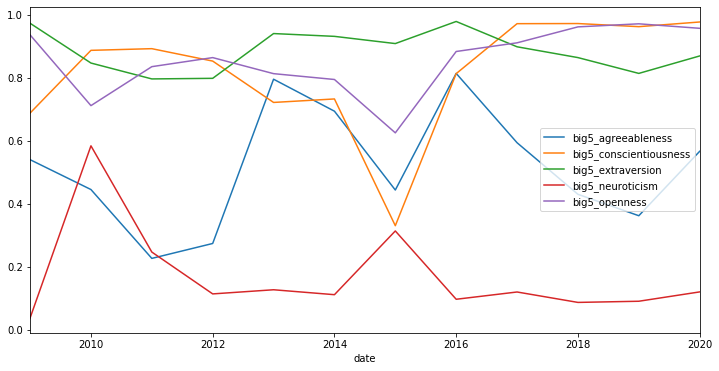

In [125]:
column_selection = [ col for col in yearly_profile.columns if 'big5' in col and not 'raw' in col and not '_significant' in col]
yearly_profile[column_selection].plot()

In [ ]:
from dateutil import relativedelta

time_delta = relativedelta.relativedelta(tweets.index.max(), tweets.index.min())
print(f'[INFO] Donald Trump tweeted {tweets.shape[0]} times in a span of {time_delta.years} years.')